In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV,cross_val_score,train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import tensorflow as tf
from tensorflow import python
from tensorflow import metrics

import warnings
warnings.filterwarnings('ignore')

# np.random.seed(1)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(r'./dataset/air_quality_data_fix.csv')

In [3]:
df.head()

,latitude,longitude,dateTime,regionCode,universal_aqi,universal_aqi_category,dominant_pollutant,co,no2,o3,...,pm25,so2,health_general_population,health_elderly,health_lung_disease,health_heart_disease,health_athletes,health_pregnant_women,health_children,City
0,-7.294524,112.732623,2024-11-24T08:00:00Z,id,26,Low air quality,pm25,488.99,18.79,84.07,...,89.18,4.21,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
1,-7.296518,112.639345,2024-11-24T08:00:00Z,id,19,Poor air quality,pm25,489.34,8.71,89.47,...,113.85,5.66,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
2,-7.251514,112.759883,2024-11-24T08:00:00Z,id,38,Low air quality,o3,492.09,16.41,78.74,...,45.67,3.64,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
3,-7.283691,112.745216,2024-11-24T08:00:00Z,id,30,Low air quality,pm25,489.48,14.84,82.55,...,75.29,3.98,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya
4,-7.262437,112.721854,2024-11-24T08:00:00Z,id,30,Low air quality,pm25,491.03,16.86,82.08,...,75.09,4.18,Reduce the intensity of your outdoor activitie...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Avoid intense activities outdoors or postpone ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,The current level of air quality is likely to ...,Surabaya


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   1300 non-null   float64
 1   longitude                  1300 non-null   float64
 2   dateTime                   1300 non-null   object 
 3   regionCode                 1300 non-null   object 
 4   universal_aqi              1300 non-null   int64  
 5   universal_aqi_category     1300 non-null   object 
 6   dominant_pollutant         1300 non-null   object 
 7   co                         1300 non-null   float64
 8   no2                        1300 non-null   float64
 9   o3                         1300 non-null   float64
 10  pm10                       1300 non-null   float64
 11  pm25                       1300 non-null   float64
 12  so2                        1300 non-null   float64
 13  health_general_population  1300 non-null   objec

In [5]:
df.describe()

,latitude,longitude,universal_aqi,co,no2,o3,pm10,pm25,so2
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,-6.857125,109.334388,42.575385,703.795823,20.990992,55.190692,57.212162,44.336923,10.673631
std,0.403516,2.718074,10.434871,216.403107,13.808348,24.125248,9.670715,20.335404,7.360566
min,-7.296518,106.702056,19.000000,488.990000,5.590000,17.000000,32.460000,7.760000,3.510000
25%,-7.265678,106.863201,36.000000,490.940000,10.270000,24.000000,50.500000,20.532500,4.020000
50%,-6.918964,107.624402,38.000000,657.625000,15.900000,54.330000,55.595000,50.610000,8.440000
75%,-6.365584,112.737891,55.000000,967.790000,37.042500,80.100000,65.320000,56.770000,19.132500
max,-6.200522,112.769123,71.000000,1045.230000,48.480000,89.470000,113.850000,113.850000,25.260000


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [7]:
# Pisahkan fitur (X) dan target (y)
X = df[['co', 'no2', 'o3', 'pm10','pm25','so2']]
y = df['universal_aqi']

In [8]:
# Pastikan y diubah menjadi array numpy sebelum reshape
y = y.values.reshape(-1, 1)

# Normalisasi data menggunakan MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)


In [9]:
# 5. Mengubah data menjadi bentuk sekuensial untuk RNN/LSTM (samples, timesteps, features)
timesteps = 5  # Menggunakan 5 timestep sebelumnya untuk prediksi
X_seq, y_seq = [], []
for i in range(len(X) - timesteps):
    X_seq.append(X[i:i + timesteps])
    y_seq.append(y[i + timesteps])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [10]:
# 6. Membagi data menjadi train set dan test set
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, activation='tanh', input_shape=(timesteps, X_seq.shape[2])),
    Dropout(0.2),
    SimpleRNN(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])

In [43]:
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [44]:
# Menambahkan callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang dipantau
    patience=10,         # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik
)

In [45]:
# Melatih model RNN dengan EarlyStopping
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=50,  # Maksimal epoch
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Tambahkan EarlyStopping di sini
)

Epoch 1/50


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1683 - mae: 0.3092 - val_loss: 0.0118 - val_mae: 0.0880
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0257 - mae: 0.1291 - val_loss: 0.0064 - val_mae: 0.0664
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - mae: 0.0831 - val_loss: 0.0044 - val_mae: 0.0522
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - mae: 0.0639 - val_loss: 0.0041 - val_mae: 0.0491
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - mae: 0.0581 - val_loss: 0.0036 - val_mae: 0.0458
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0554 - val_loss: 0.0031 - val_mae: 0.0404
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0549 - val_loss: 0.0033 - val_mae: 0.0432
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0536 - val_loss: 0.0030 - val_mae: 0.0403
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - mae: 0.0499 - v

In [46]:
# 9. Membuat model LSTM
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', input_shape=(timesteps, X_seq.shape[2]))),
    Dropout(0.2),
    LSTM(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [47]:
# Melatih model LSTM dengan EarlyStopping
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,  # Maksimal epoch
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Tambahkan EarlyStopping di sini
)

Epoch 1/50


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.1037 - mae: 0.2550 - val_loss: 0.0039 - val_mae: 0.0521
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0637 - val_loss: 0.0038 - val_mae: 0.0518
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0555 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - mae: 0.0559 - val_loss: 0.0037 - val_mae: 0.0512
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0547 - val_loss: 0.0047 - val_mae: 0.0599
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - mae: 0.0581 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mae: 0.0560 - val_loss: 0.0036 - val_mae: 0.0506
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mae: 0.0569 - val_loss: 0.0035 - val_mae: 0.0465
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mae: 0.053

In [48]:
# 11. Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - mae: 0.0267 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0507 


In [49]:
# 12. Menampilkan hasil evaluasi
results = {
    'RNN': {'Loss': rnn_loss, 'MAE': rnn_mae},
    'LSTM': {'Loss': lstm_loss, 'MAE': lstm_mae}
}

print("Hasil Evaluasi Model:")
print(results)

Hasil Evaluasi Model:
{'RNN': {'Loss': 0.0018814519280567765, 'MAE': 0.028414245694875717}, 'LSTM': {'Loss': 0.003918241243809462, 'MAE': 0.05207616835832596}}


In [50]:
# Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)
# Menampilkan akurasi
# Hitung akurasi sebagai 1 - Normalized MAE
y_test_inv = scaler_y.inverse_transform(y_test)  # Kembalikan skala asli untuk interpretasi
mae_rnn_scaled = scaler_y.inverse_transform([[rnn_mae]])[0][0]  # MAE RNN dalam skala asli
mae_lstm_scaled = scaler_y.inverse_transform([[lstm_mae]])[0][0]  # MAE LSTM dalam skala asli

accuracy_rnn = (1 - (mae_rnn_scaled / np.mean(y_test_inv))) * 100  # Akurasi RNN dalam persentase
accuracy_lstm = (1 - (mae_lstm_scaled / np.mean(y_test_inv))) * 100  # Akurasi LSTM dalam persentase

# Menampilkan hasil
print("Hasil Evaluasi Model:")
print(f"RNN - Loss (MSE): {rnn_loss:.4f}, MAE: {rnn_mae:.4f}, Akurasi: {accuracy_rnn:.2f}%")
print(f"LSTM - Loss (MSE): {lstm_loss:.4f}, MAE: {lstm_mae:.4f}, Akurasi: {accuracy_lstm:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0267 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0507 
Hasil Evaluasi Model:
RNN - Loss (MSE): 0.0019, MAE: 0.0284, Akurasi: 52.15%
LSTM - Loss (MSE): 0.0039, MAE: 0.0521, Akurasi: 49.28%


In [51]:
# Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)

# Hitung akurasi dalam skala 0-1
# 1 - Normalized MAE
normalized_rnn_mae = rnn_mae / np.mean(y_test)  # Normalisasi MAE RNN
normalized_lstm_mae = lstm_mae / np.mean(y_test)  # Normalisasi MAE LSTM

accuracy_rnn = 1 - normalized_rnn_mae
accuracy_lstm = 1 - normalized_lstm_mae

# Menampilkan hasil
print("Hasil Evaluasi Model:")
print(f"RNN - Loss (MSE): {rnn_loss:.4f}, MAE: {rnn_mae:.4f}, Akurasi: {accuracy_rnn:.4f}")
print(f"LSTM - Loss (MSE): {lstm_loss:.4f}, MAE: {lstm_mae:.4f}, Akurasi: {accuracy_lstm:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0267 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0507 
Hasil Evaluasi Model:
RNN - Loss (MSE): 0.0019, MAE: 0.0284, Akurasi: 0.9379
LSTM - Loss (MSE): 0.0039, MAE: 0.0521, Akurasi: 0.8862


In [52]:
# Pilih data terakhir dari data uji untuk memulai prediksi
last_input = X_test[-1]  # Data terakhir dalam bentuk (timesteps, features)

# Membuat tempat untuk menyimpan prediksi
predictions = []

# Iterasi untuk menghasilkan prediksi 3 hari ke depan
for _ in range(3):  # 3 hari ke depan
    # Prediksi berdasarkan input terakhir
    prediction = lstm_model.predict(last_input.reshape(1, last_input.shape[0], last_input.shape[1]))
    
    # Simpan hasil prediksi
    predictions.append(prediction[0, 0])
    
    # Perbarui input untuk prediksi berikutnya
    # Bentuk prediksi menjadi (1, features) agar sesuai dengan timestep
    prediction_reshaped = np.full((1, last_input.shape[1]), prediction[0, 0])  # Sesuaikan dimensi prediksi
    
    # Geser data input (buang timestep paling awal, tambahkan prediksi baru)
    next_input = np.vstack([last_input[1:], prediction_reshaped])  # Gabungkan dengan prediksi baru
    last_input = next_input

# Inverse transform hasil prediksi untuk kembali ke skala asli
predictions_scaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Output prediksi 3 hari ke depan
for i, pred in enumerate(predictions_scaled.flatten(), 1):
    print(f"Prediksi hari ke-{i}: {pred:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediksi hari ke-1: 36.7631
Prediksi hari ke-2: 38.1519
Prediksi hari ke-3: 39.3374


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluasi model pada data uji
y_pred_test = lstm_model.predict(X_test)

# Inverse transform hasil prediksi dan data aktual
y_pred_test_scaled = scaler_y.inverse_transform(y_pred_test)
y_test_scaled = scaler_y.inverse_transform(y_test)

# Hitung akurasi menggunakan metrik MAE dan MSE
mae = mean_absolute_error(y_test_scaled, y_pred_test_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_test_scaled)
accuracy = 1 - (mae / np.mean(y_test_scaled))  # Akurasi dalam skala 0-1

# Tampilkan akurasi
print(f"Akurasi Model (skala 0-1): {accuracy:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Prediksi 3 hari ke depan
last_input = X_test[-1]
predictions = []

for _ in range(3):  # Prediksi 3 hari ke depan
    prediction = lstm_model.predict(last_input.reshape(1, last_input.shape[0], last_input.shape[1]))
    predictions.append(prediction[0, 0])
    prediction_reshaped = np.full((1, last_input.shape[1]), prediction[0, 0])
    next_input = np.vstack([last_input[1:], prediction_reshaped])
    last_input = next_input

# Inverse transform hasil prediksi untuk kembali ke skala asli
predictions_scaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Output prediksi 3 hari ke depan
print("\nPrediksi 3 Hari ke Depan:")
for i, pred in enumerate(predictions_scaled.flatten(), 1):
    print(f"Hari ke-{i}: {pred:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
Akurasi Model (skala 0-1): 0.9367
Mean Absolute Error (MAE): 2.7080
Mean Squared Error (MSE): 10.5949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Prediksi 3 Hari ke Depan:
Hari ke-1: 36.7631
Hari ke-2: 38.1519
Hari ke-3: 39.3374


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluasi model pada data uji
y_pred_test = rnn_model.predict(X_test)

# Inverse transform hasil prediksi dan data aktual
y_pred_test_scaled = scaler_y.inverse_transform(y_pred_test)
y_test_scaled = scaler_y.inverse_transform(y_test)

# Hitung akurasi menggunakan metrik MAE dan MSE
mae = mean_absolute_error(y_test_scaled, y_pred_test_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_test_scaled)
accuracy = 1 - (mae / np.mean(y_test_scaled))  # Akurasi dalam skala 0-1

# Tampilkan akurasi
print(f"Akurasi Model (skala 0-1): {accuracy:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Ambil 3 input terakhir dari data uji
last_inputs = X_test[-3:]  # Mengambil 3 input terakhir
predictions = []

for _ in range(3):  # Prediksi 3 hari ke depan
    # Prediksi untuk setiap timestep
    current_input = last_inputs[-1]  # Gunakan input terakhir untuk prediksi
    prediction = lstm_model.predict(current_input.reshape(1, current_input.shape[0], current_input.shape[1]))
    predictions.append(prediction[0, 0])

    # Update input: Tambahkan prediksi terbaru sebagai langkah berikutnya
    prediction_reshaped = np.full((1, current_input.shape[1]), prediction[0, 0])  # Sesuaikan dengan fitur
    next_input = np.vstack([current_input[1:], prediction_reshaped])  # Geser dan tambahkan prediksi
    last_inputs = np.append(last_inputs[1:], [next_input], axis=0)  # Update 3 input terakhir

# Inverse transform hasil prediksi untuk kembali ke skala asli
predictions_scaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Output prediksi 3 hari ke depan
print("\nPrediksi 3 Hari ke Depan:")
for i, pred in enumerate(predictions_scaled.flatten(), 1):
    print(f"Hari ke-{i}: {pred:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Akurasi Model (skala 0-1): 0.9655
Mean Absolute Error (MAE): 1.4775
Mean Squared Error (MSE): 5.0874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Prediksi 3 Hari ke Depan:
Hari ke-1: 36.7631
Hari ke-2: 38.1519
Hari ke-3: 39.3374


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluasi model pada data uji
y_pred_test = lstm_model.predict(X_test)

# Inverse transform hasil prediksi dan data aktual
y_pred_test_scaled = scaler_y.inverse_transform(y_pred_test)
y_test_scaled = scaler _y.inverse_transform(y_test)

# Hitung akurasi menggunakan metrik MAE dan MSE
mae = mean_absolute_error(y_test_scaled, y_pred_test_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_test_scaled)
accuracy = 1 - (mae / np.mean(y_test_scaled))  # Akurasi dalam skala 0-1

# Tampilkan akurasi
print(f"Akurasi Model (skala 0-1): {accuracy:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Ambil 3 input terakhir dari data uji
last_inputs = X_test[-3:]  # Mengambil 3 input terakhir
predictions = []

for _ in range(3):  # Prediksi 3 hari ke depan
    # Prediksi untuk setiap timestep
    current_input = last_inputs[-1]  # Gunakan input terakhir untuk prediksi
    prediction = lstm_model.predict(current_input.reshape(1, current_input.shape[0], current_input.shape[1]))
    predictions.append(prediction[0, 0])

    # Update input: Tambahkan prediksi terbaru sebagai langkah berikutnya
    prediction_reshaped = np.full((1, current_input.shape[1]), prediction[0, 0])  # Sesuaikan dengan fitur
    next_input = np.vstack([current_input[1:], prediction_reshaped])  # Geser dan tambahkan prediksi
    last_inputs = np.append(last_inputs[1:], [next_input], axis=0)  # Update 3 input terakhir

# Inverse transform hasil prediksi untuk kembali ke skala asli
predictions_scaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Output prediksi 3 hari ke depan
print("\nPrediksi 3 Hari ke Depan:")
for i, pred in enumerate(predictions_scaled.flatten(), 1):
    print(f"Hari ke-{i}: {pred:.4f}")


 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Akurasi Model (skala 0-1): 0.9297
Mean Absolute Error (MAE): 3.0084
Mean Squared Error (MSE): 12.3843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Prediksi 3 Hari ke Depan:
Hari ke-1: 36.7647
Hari ke-2: 38.2141
Hari ke-3: 39.6868


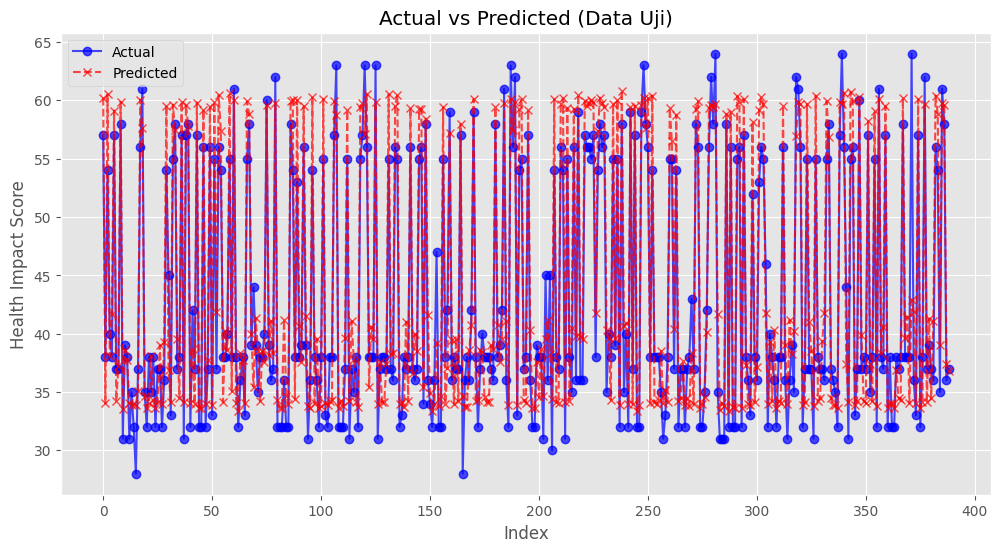

In [39]:
import matplotlib.pyplot as plt

# Visualisasi hasil prediksi vs data aktual untuk data uji
plt.figure(figsize=(12, 6))

# Plot data aktual
plt.plot(y_test_scaled.flatten(), label="Actual", color="blue", linestyle="-", marker="o", alpha=0.7)
# Plot data prediksi
plt.plot(y_pred_test_scaled.flatten(), label="Predicted", color="red", linestyle="--", marker="x", alpha=0.7)

# Tambahkan detail pada grafik
plt.title("Actual vs Predicted (Data Uji)")
plt.xlabel("Index")
plt.ylabel("Health Impact Score")
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.show()


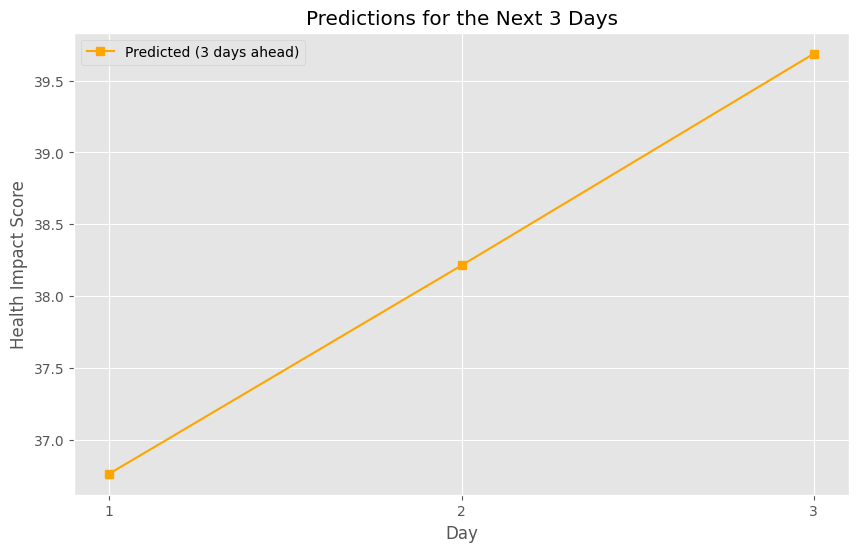

In [40]:
# Visualisasi prediksi 3 hari ke depan
plt.figure(figsize=(10, 6))

# Plot prediksi 3 hari ke depan
plt.plot(range(1, 4), predictions_scaled.flatten(), label="Predicted (3 days ahead)", linestyle='-', marker='s', color='orange')

# Tambahkan detail pada grafik
plt.title("Predictions for the Next 3 Days")
plt.xlabel("Day")
plt.ylabel("Health Impact Score")
plt.xticks(range(1, 4))
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.show()


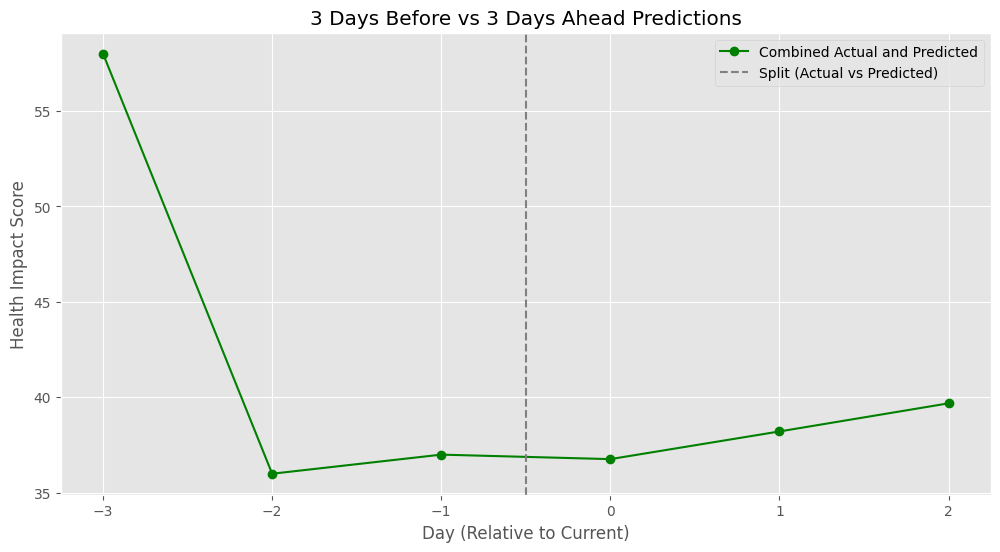

In [41]:
# Fix the dimensions issue by ensuring `days` and `combined_values` have the same length

# Dummy data for demonstration (Replace with actual values)
# Assuming the last 3 actual values from y_test_scaled represent the 3 days before prediction
last_3_actual = y_test_scaled[-3:].flatten()  # Replace with the last 3 actual values
predicted_3_days = predictions_scaled.flatten()  # Replace with actual predictions for 3 days ahead

# Combine last 3 actual and 3 predicted values
combined_values = np.concatenate((last_3_actual, predicted_3_days))

# Correct `days` to match the length of `combined_values`
days = range(-3, 3)  # 3 days before (-3 to -1) and 3 days ahead (0 to 2)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(days, combined_values, label="Combined Actual and Predicted", linestyle='-', marker='o', color='green')

# Highlight the split between actual and predicted
plt.axvline(x=-0.5, color='gray', linestyle='--', label="Split (Actual vs Predicted)")

# Tambahkan detail pada grafik
plt.title("3 Days Before vs 3 Days Ahead Predictions")
plt.xlabel("Day (Relative to Current)")
plt.ylabel("Health Impact Score")
plt.xticks(days)
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.show()
